# Anime Recommendation System Project

## Imported Libraries

#### Common Data Science Libraries

In [49]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#### Surprise Libary (for SVD and KNN models)

In [50]:
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV
from surprise.model_selection import cross_validate
from surprise.prediction_algorithms import KNNWithMeans, KNNBasic, KNNBaseline
from surprise.prediction_algorithms import knns
from surprise.prediction_algorithms import SVD
from surprise.similarities import cosine, msd, pearson
from surprise import accuracy
from surprise import Reader
from surprise import Dataset

## Datasets

#### Main Anime Dataset (anime.csv)

In [51]:
anime_df = pd.read_csv("data/anime.csv")

In [52]:
print(anime_df.shape)
print(anime_df.columns.unique())
anime_df.head()

(17562, 35)
Index(['MAL_ID', 'Name', 'Score', 'Genres', 'English name', 'Japanese name',
       'Type', 'Episodes', 'Aired', 'Premiered', 'Producers', 'Licensors',
       'Studios', 'Source', 'Duration', 'Rating', 'Ranked', 'Popularity',
       'Members', 'Favorites', 'Watching', 'Completed', 'On-Hold', 'Dropped',
       'Plan to Watch', 'Score-10', 'Score-9', 'Score-8', 'Score-7', 'Score-6',
       'Score-5', 'Score-4', 'Score-3', 'Score-2', 'Score-1'],
      dtype='object')


,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,229170,182126,131625,62330,20688,8904,3184,1357,741,1580
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,1-Sep-01,Unknown,...,30043,49201,49505,22632,5805,1877,577,221,109,379
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,トライガン,TV,26,"Apr 1, 1998 to Sep 30, 1998",Spring 1998,...,50229,75651,86142,49432,15376,5838,1965,664,316,533
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),TV,26,"Jul 2, 2002 to Dec 24, 2002",Summer 2002,...,2182,4806,10128,11618,5709,2920,1083,353,164,131
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",Beet the Vandel Buster,冒険王ビィト,TV,52,"Sep 30, 2004 to Sep 29, 2005",Fall 2004,...,312,529,1242,1713,1068,634,265,83,50,27


#### Anime Ratings Dataset (rating_complete.csv)

In [53]:
ratings_df = pd.read_csv("data/rating_complete.csv")

In [54]:
print(ratings_df.shape)
print(ratings_df.columns.unique())
ratings_df.head()

(57633278, 3)
Index(['user_id', 'anime_id', 'rating'], dtype='object')


,user_id,anime_id,rating
0,0,430,9
1,0,1004,5
2,0,3010,7
3,0,570,7
4,0,2762,9


#### CSV for mapping Name to ID used by app.py (id_to_name.csv)

In [55]:
name_to_id_df = anime_df[['MAL_ID', 'Name', 'English name']]
name_to_id_df.to_csv('data/id_to_name.csv', index=False)

#### Dataset Cleaning

In [56]:
print("Before:")
print(anime_df.shape)
print(ratings_df.shape)

anime_df.dropna(inplace=True)
ratings_df.dropna(inplace=True)

print("\nAfter:")
print(anime_df.shape)
print(ratings_df.shape)

Before:
(17562, 35)
(57633278, 3)

After:
(17562, 35)
(57633278, 3)


## Data Visualizations

Rating Counts:


8     14642156
7     13325549
9      9773857
6      6849293
10     6716048
5      3436250
4      1455102
3       696048
2       405556
1       333419
Name: rating, dtype: int64

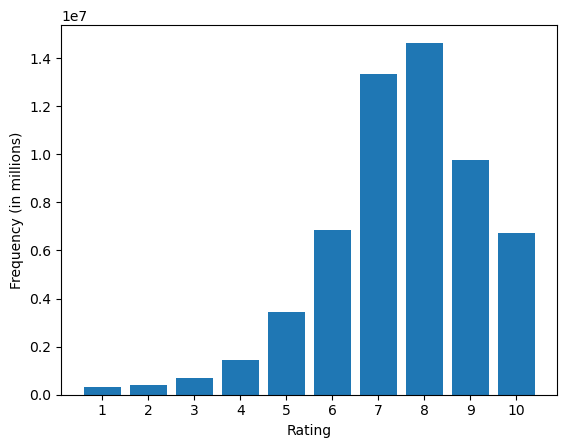

In [57]:
rating_values = ratings_df['rating'].unique()
rating_counts = ratings_df['rating'].value_counts()
plt.bar(rating_counts.index, rating_counts)
plt.xlabel("Rating")
plt.xticks(rating_values)
plt.ylabel("Frequency (in millions)")

print("Rating Counts:")
ratings_df['rating'].value_counts()

In [59]:
# returns bounds to be considered outlier based on IQR method
def iqr_bounds(value_counts):
    quartiles = np.percentile(value_counts, [25, 50, 75])
    iqr = quartiles[2] - quartiles[0]
    lower = quartiles[0] - 1.5 * iqr
    upper = quartiles[2] + 1.5 * iqr
    return lower, upper

# plots both a histogram and boxplot for user ratings per anime and user in a 4x4 grid
def plot_distributions(df):
    fig, axs = plt.subplots(2, 2, figsize=(8, 8))
    fig.tight_layout(pad=5)

    x_labels = ["Ratings Count Per Anime", "Ratings Count Per User"]

    for idx, column in enumerate(['anime_id', 'user_id']):
        value_counts = df[column].value_counts()
        lower, upper = iqr_bounds(value_counts)
        value_counts = value_counts[(value_counts >= lower) & (value_counts <= upper)]

        axs[0, idx].hist(value_counts, bins=50, edgecolor = "black")
        axs[0, idx].set_xlabel(x_labels[idx])
        axs[0, idx].set_ylabel("Frequency")

        axs[1, idx].boxplot(value_counts, vert=False)
        axs[1, idx].set_xlabel(x_labels[idx])
        axs[1, idx].set_yticks([])

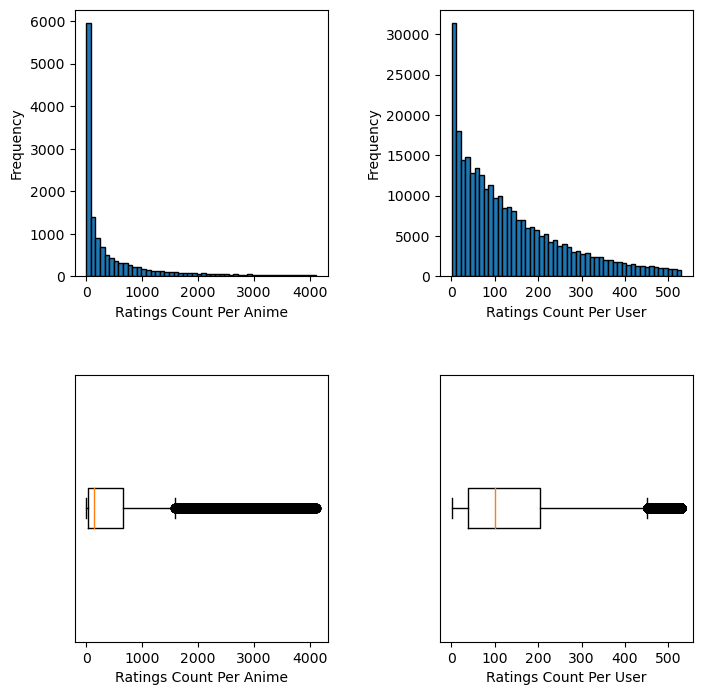

In [60]:
plot_distributions(ratings_df)

In [61]:
ratings_count = ratings_df['anime_id'].value_counts()
print(f'Number of rated anime: {len(ratings_count)}')
print(f'Total number of anime: {len(anime_df)}')
print(f'Percentage of rated anime: {(len(ratings_count) / len(anime_df) * 100):.2f}%')

Number of rated anime: 16872
Total number of anime: 17562
Percentage of rated anime: 96.07%


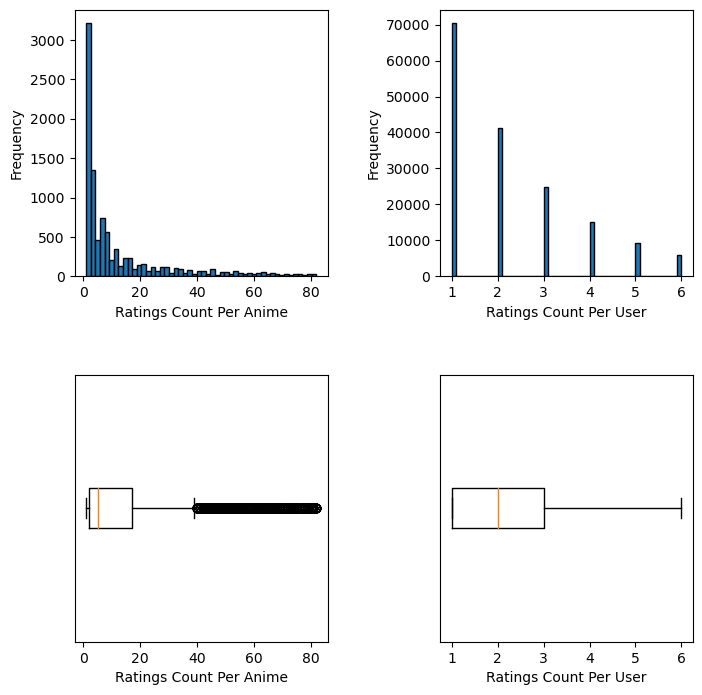

In [62]:
rating_sample = ratings_df.sample(n=500000)
plot_distributions(rating_sample)

#### Surprise Libary (for SVD and KNN models)

In [ ]:
# unique Genre values
genres = anime_main['Genres']
genres = pd.DataFrame([sub.split(",") for sub in genres])
pd.unique(genres.values.ravel('K'))

In [ ]:
# Create ID to name dictionary
def read_item_names():
    file_name = "data/anime.csv"
    rid_to_name = {}
    name_to_rid = {}
    with open(file_name, encoding="ISO-8859-1") as f:
        # skip header line
        next(f)
        for line in f:
            line = line.split(",")
            rid_to_name[line[0]] = line[1]
            name_to_rid[line[1]] = line[0]

    return rid_to_name, name_to_rid

rid_to_name, name_to_rid = read_item_names()

In [ ]:
# From a dataframe sample all the ratings from N random users, using 'User ID'
def sample_n_user_ratings(source_df, n):
    users = source_df['user_id'].unique()
    user_id_set = set(np.random.choice(users, size=n, replace=False))

    result_df = source_df[source_df['user_id'].isin(user_id_set)].copy()
    
    return result_df


## Grid Search / SVD

Data Setup

In [ ]:
count_sample = sample_n_user_ratings(ratings_df,4000)
count_sample = count_sample[['user_id', 'anime_id', 'rating']]
print('Sampled User Count: {}'.format(len(count_sample['user_id'].unique())))
print('Sampled Unique Anime Rated: {}'.format(len(count_sample['anime_id'].unique())))

In [ ]:
# Sample subset of data
svd_ratings_sample = sample_n_user_ratings(ratings_df,2000)
svd_ratings_sample = svd_ratings_sample[['user_id', 'anime_id', 'rating']]

In [ ]:
# Save as file for frontend usage
svd_ratings_sample.to_csv('data/frontend_svd_sample.csv', index=False)

In [ ]:
def create_dataset_from_df(df):
    reader = Reader(rating_scale=(1,10))
    return Dataset.load_from_df(df, reader)

# Read into Suprise dataset
svd_ratings_dataset =create_dataset_from_df(svd_ratings_sample)

Grid Search

In [ ]:
# Grid search for optimal hyperparameters
param_grid = {
    'lr_all' : [.01],
    'n_factors' : [50, 75, 100],
    'reg_all': [.1],
    'n_epochs' : [50, 100, 150]
}
gridsearch_svd = GridSearchCV(
    SVD, 
    param_grid = param_grid, 
    n_jobs = -1, 
    joblib_verbose = 3)

gridsearch_svd.fit(svd_ratings_dataset)

print(gridsearch_svd.best_score)
print(gridsearch_svd.best_params)


Training Model Instance

In [ ]:
# Create model instance from grid search optimal hyperparameters
svd_instance = gridsearch_svd.best_estimator["rmse"]
# Print Params
print(svd_instance.__dict__)

In [ ]:
# Graph RMSE over training epochs
svd_instance.fit(svd_ratings_dataset.build_full_trainset())

In [ ]:

mse_per_epoch = svd_instance.history['rmse']

for epoch, mse in enumerate(mse_per_epoch, start=1):
    print(f"Epoch {epoch}: MSE = {mse}")

Basic SVD Rating Prediction Recommendation System

In [ ]:
# Appends a new user to the df for refitting and predicting
# We need to do this because suprise does not support iterative training with SVD
def create_predict_dataset(base_df, anime_ids, ratings):
    predictor_df = base_df.copy()
    for i in range(len(anime_ids)):
        predictor_df.loc[len(predictor_df)] = [-1,anime_ids[i], ratings[i]]
    
    return create_dataset_from_df(predictor_df)


In [ ]:

# Displays predictions for some user ID
# TODO: Should display name of anime
def show_predictions(model_instance, user_id, anime_ids, ratings_df):
    for anime_id in anime_ids:
        condition = (ratings_df['User ID'] == user_id) & (ratings_df['Anime ID'] == anime_id)
        model_instance.predict(
            user_id, 
            anime_id, 
            #ratings_df.loc[condition, 'Rating'],
            verbose = True)

# Creates a dataframe for the predictions
def get_predictions(model_instance, user_id, anime_ids):

    predict_ratings = pd.DataFrame(columns=['Anime ID', 'Rating'])

    # Use suprise model predict method to get predictions
    # This only works on userIDs that were in the training set
    for anime_id in anime_ids:
        prediction = model_instance.predict(
            user_id, 
            anime_id)

        predict_ratings.loc[len(predict_ratings)] = [anime_id, prediction.est]

    return predict_ratings

In [ ]:
# print(anime_ratings[anime_ratings['User ID'] == 35])
# show_predictions(svd_instance, 35, [64, 6707, 6547, 4898], svd_ratings_sample)

In [ ]:
# Create predictions for a mew user provided their anime ratings
# This refits the entire model with the new user appended onto the base df with a user ID of -1

def create_predictions_for_user(model_instance, base_df, anime_ids, ratings):

    # Create suprise dataset with new user
    predict_dataset = create_predict_dataset(
        base_df, 
        anime_ids,
        ratings)

    # Train on entire dataset
    # TODO: Should we do this?
    model_instance.fit(predict_dataset.build_full_trainset())
    # model_instance.fit(full_trainset)

    # Create a series of all the anime IDs that want to be predicted (all of them, more or less)
    predict_anime_ids = base_df['Anime ID'];
    predict_anime_ids = predict_anime_ids.append(pd.Series(anime_ids)).unique()
    
    # Show predictions for the known ratings
    # show_predictions(model_instance, -1, anime_ids, svd_ratings_sample)

    # Generate and return predictions for all the anime
    return get_predictions(model_instance, -1, predict_anime_ids)

# Print out information for top N predictions
def display_top_n(predictions, n):
    # Sort descending
    predictions = predictions.sort_values('Rating', ascending=False)
    
    print(predictions)
    print("Top {} predicted scores".format(n))
    # Print information about top n
    for index, row in predictions.head(n).iterrows():
        anime_id = row['Anime ID']
        rating = row['Rating']
        name = rid_to_name[str(int(anime_id))]
        print("Anime: {} Rating: {} Name: {}".format(anime_id, rating, name))

In [ ]:
# User 1 
# Drama / romance

user_1_anime_ids = [4224, 23273, 1723, 32281, 37450, 2167, 121]
user_1_ratings = [10, 8, 9, 9, 10, 9, 4]

# No randomness between each fit
svd_instance.random_state = 1

user_1_predictions = create_predictions_for_user(
    svd_instance,
    svd_ratings_sample,
    user_1_anime_ids,
    user_1_ratings
    )

display_top_n(user_1_predictions, 25)

In [ ]:
# User 2 
# Action / Adventure
user_2_pred = create_predictions_for_user(
    svd_instance,
    svd_ratings_sample,
    [114, 31964, 32051, 34134, 38000],
    [9, 10, 8, 9, 9]
    )

display_top_n(user_2_pred, 25)

In [ ]:
# User 3 
# Boys Love
user_3_anime_ids = [114, 31964, 32051, 34134, 38000, 39533, 30346, 44055, 918]
user_3_ratings = [4, 5, 4, 6, 4, 10, 10, 9, 4]

user_3_predictions = create_predictions_for_user(
    svd_instance,
    svd_ratings_sample,
    user_3_anime_ids,
    user_3_ratings
)

display_top_n(user_3_predictions, 25)

In [ ]:
# from collections import defaultdict

# def get_top_n(predictions, n = 10):
#     top_n = defaultdict(list)
#     for uid, iid, true_r, est, _ in predictions:
#         top_n[uid].append((iid, est))

#     # Then sort the predictions for each user and retrieve the k highest ones.
#     for uid, user_ratings in top_n.items():
#         user_ratings.sort(key=lambda x: x[1], reverse=True)
#         top_n[uid] = user_ratings[:n]

#     return top_n

In [ ]:
# top_anime = get_top_n(anime_predictions,n=10)

# for uid, user_ratings in top_anime.items():
#     if len([iid for (iid, _) in user_ratings]) == 10:
#         print(uid, [iid for (iid, _) in user_ratings])

In [ ]:
# user_id = -1
# anime_ids = []
# for uid, user_ratings in top_anime.items():
#     if len([iid for (iid, _) in user_ratings]) == 10:
#         user_id = uid
#         anime_ids = [iid for (iid, _) in user_ratings]
#         break
# print(user_id, anime_ids)

In [ ]:
# for anime_id in anime_ids:
#     print(anime_main.loc[anime_main['Anime ID'] == anime_id]['Name'].to_string(index=False))

## KNN 

In [ ]:
knn_anime_sample = sample_n_user_ratings(anime_df,2000)
knn_anime_sample = knn_anime_sample[['User ID', 'Anime ID', 'Rating']]

reader = Reader(rating_scale=(1,10))
knn_anime_data = Dataset.load_from_df(knn_anime_sample, reader)

knn_anime_trainset = knn_anime_data.build_full_trainset()
knn_anime_testset = knn_anime_trainset.build_anti_testset()

In [ ]:
simulation_variables = {"Name" : "pearson_baseline", "user_based" : False, "min_support" : 4}
knn_baseline = KNNBasic(sim_options = simulation_variables)
knn_baseline.fit(knn_anime_trainset)

anime_name = "Kimi no Na wa."
anime_raw_id = int(name_to_rid[anime_name])
anime_inner_id = knn_baseline.trainset.to_inner_iid(anime_raw_id)

print(rid_to_name[str(knn_baseline.trainset.to_raw_iid(anime_inner_id))])

anime_neighbors = knn_baseline.get_neighbors(anime_inner_id, k=10)

for inner_id in anime_neighbors:
    print(rid_to_name[str(knn_baseline.trainset.to_raw_iid(inner_id))])

anime_neighbors = (
    knn_baseline.trainset.to_raw_iid(inner_id) for inner_id in anime_neighbors
)

anime_neighbors = (rid_to_name[str(rid)] for rid in anime_neighbors)

In [ ]:
print(anime_raw_id)

In [ ]:
print("The 10 nearest neighbors of", anime_name, "are:")
for anime in anime_neighbors:
    print(anime)

## Cross Validation

In [ ]:
knn_basic = KNNBasic(sim_options = {'name':'pearson','user_based':True})

cv_knn_baseline = cross_validate(knn_basic, knn_anime_data, n_jobs=-1)
print(np.mean(cv_knn_baseline['test_rmse']))

In [ ]:
cv_knn_baseline

## Pickle

In [ ]:
import pickle

In [ ]:
pickle.dump(knn_baseline, open('knn_model.pkl','wb'))

In [ ]:
pickle.dump(svd_instance, open('svd_model.pkl','wb'))